## Introduction

A constant density parameter might not be able to characterize the underlying structure of a real-world dataset with noise and varying cluster density.

Here, we consider a **2D synthetic dataset** with varying cluster density, as shown below.  
It consists of **four clusters**:($$C_1.....C_4$$)


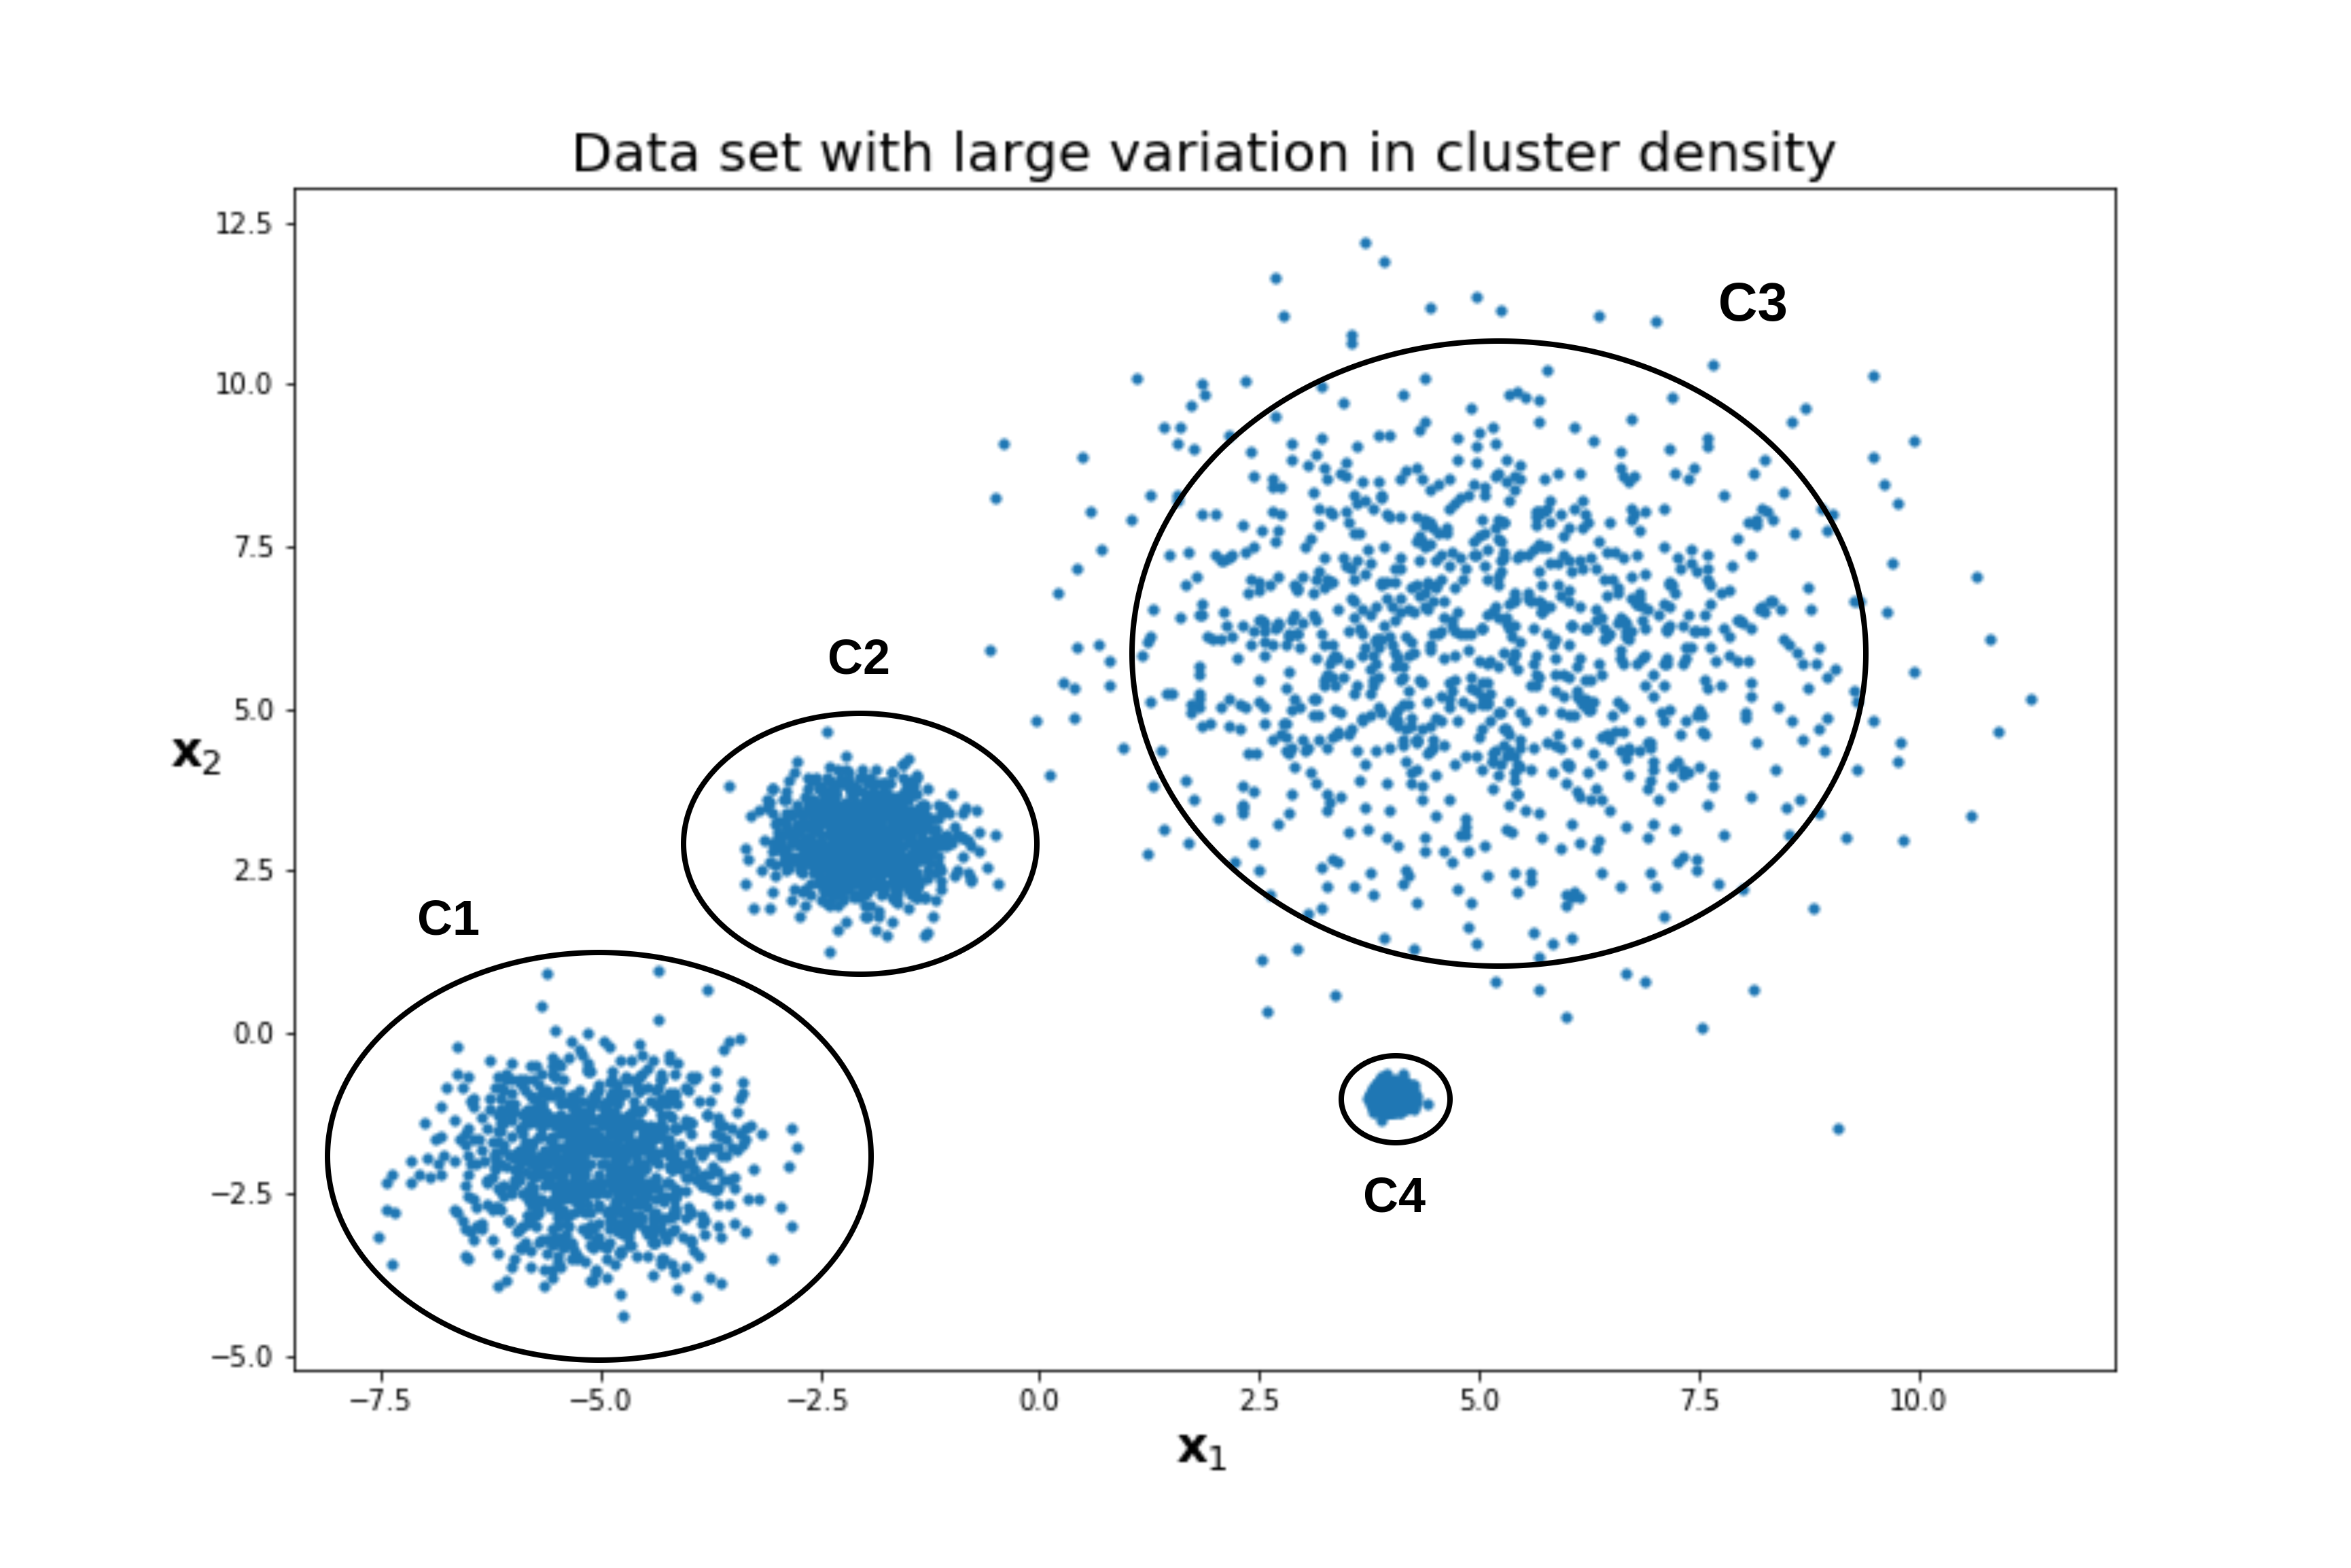

Figure 1: 2D Dataset consisting of cluster with varying density.
Varying local densities are present within each cluster. As DBSCAN assumes a constant density of the neighborhood, it's unable to cluster data point having a significant variation in density.

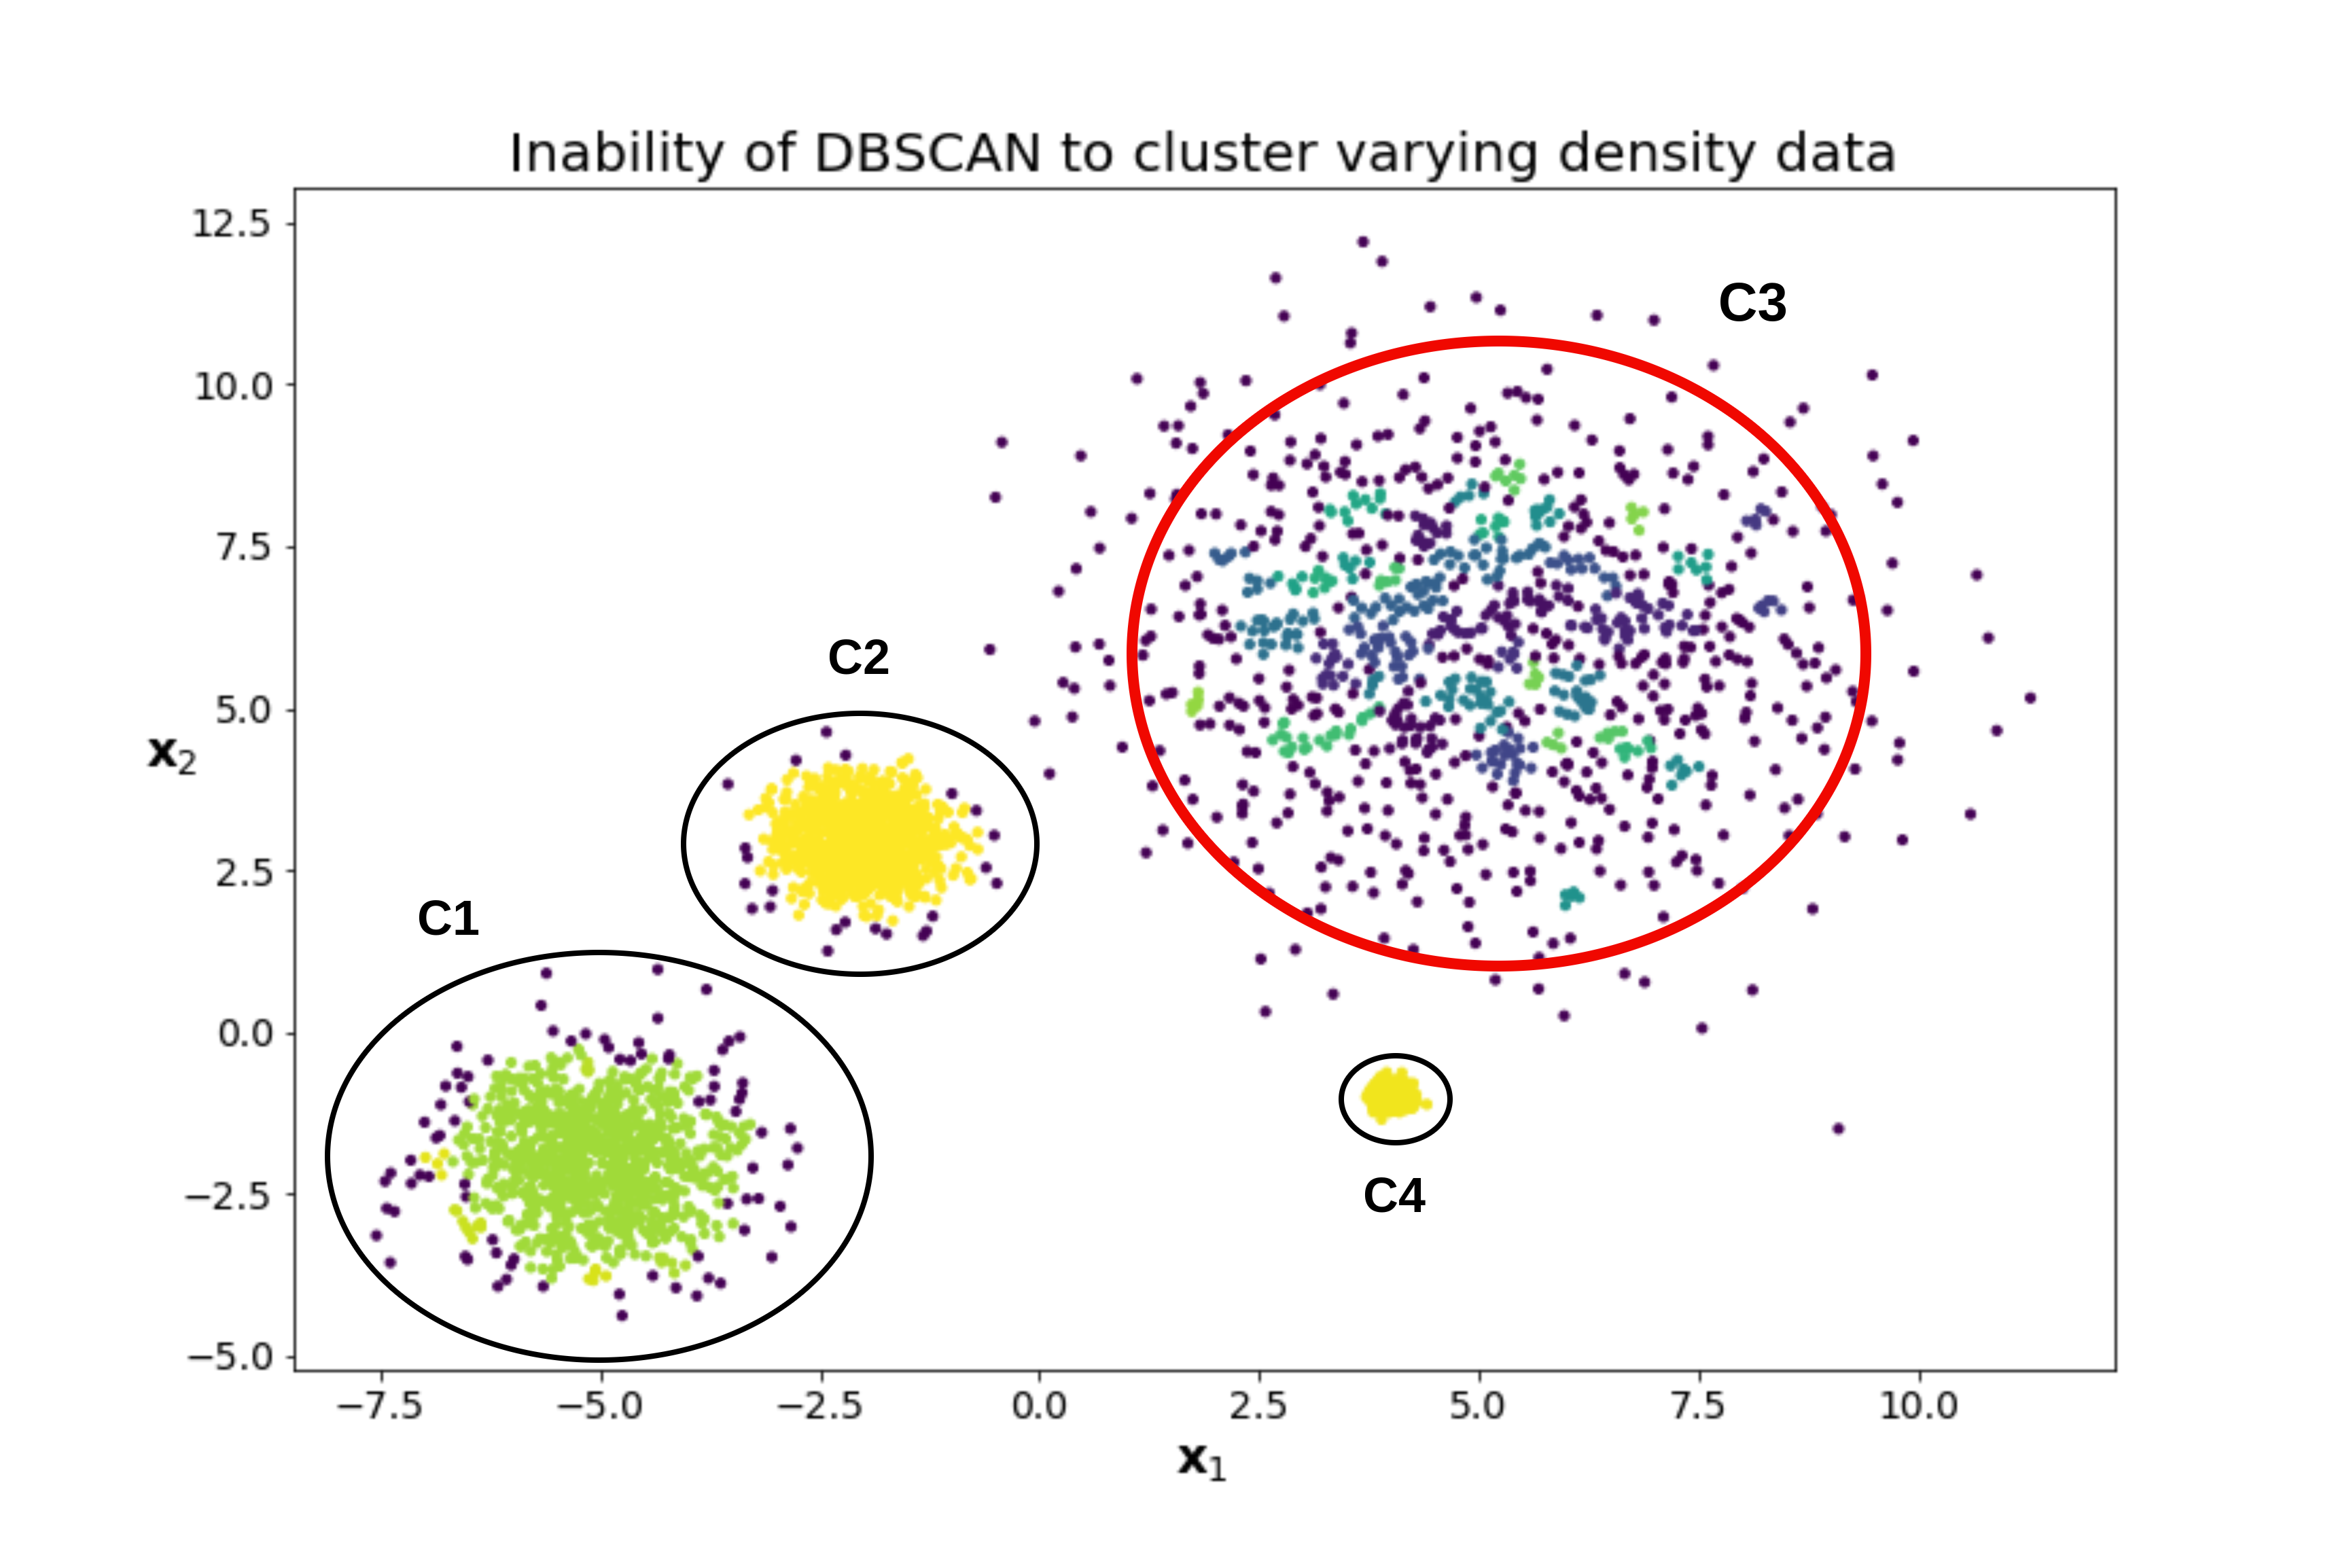

Figure 2: Inability of DBSCAN to cluster varying density clusters.
Figure 2 shows the clustering result of DBSCAN using scikit-learn with default parameters. DBSCAN identified clusters C1, C2, and C4, but failed to cluster sparse cluster C3. Assuming constant density resulted in the formation of multiple smaller clusters within C3.

To overcome this problem, in 1999, Mihael Ankerst, Markus M. Breunig, Hans-Peter Kriegel, Jörg Sander introduced Under introduced [OPTICS](https://scikit-learn.org/stable/modules/clustering.html#optics)  (Ordering Points To Identify the Clustering Structure), an extension of DBSCAN, able to find clusters in data with varying density. Note: OPTICS doesn't perform clustering explicitly, but instead creates an ordering of the data points that comprehends the density-based clustering structure, such that spatially close points are near in the ordering. Later the order is analyzed for forming clusters.

As there is no explicit clustering involved in OPTICS, the authors propose two techniques for clustering the dataset after ordering, interactive, and automatic analysis techniques. We will be looking at the interactive analysis technique in this notebook.

## Density-based cluster-ordering

OPTICS is an extension of DBSCAN, i.e., OPTICS uses all the parameters and terminologies used in DBSCAN. However, OPTICS requires knowledge of two additional terms required for ordering the cluster density. Before that, let us gain the notion of density-based cluster ordering.

As stated, OPTICS performs ordering of clusters based on the value of density. For a constant **MinPts**, higher-density clusters (low $\varepsilon$) are completely contained within lower-density clusters (high $\varepsilon$), as illustrated in the figure below.


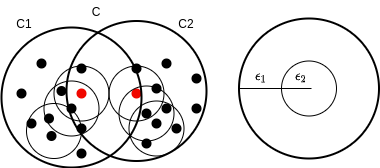

**Figure 3:** Visualization of nested nature of clusters  
*Source:* Ankerst M. et al. (1999)

As seen in Figure 3, dense clusters exist within sparse clusters. For **MinPts = 3** and $\varepsilon_2 < \varepsilon_1$, $C_1$ and $C_2$ are denser clusters with respect to $\varepsilon_2$, and the cluster $C$, which comprehends $C_1$ and $C_2$, is formed based on $\varepsilon_1$.

Using this knowledge, in principle, OPTICS extends DBSCAN by processing infinitely varying density-based clusters with several radii $(\varepsilon_i)$ that are smaller than the input parameter $\varepsilon$, i.e.,
\[
0 \le \varepsilon_i \le \varepsilon
\]
simultaneously. The difference between OPTICS and DBSCAN is that OPTICS stores the order of processing the data points according to its notion of density, without explicit cluster assignment.

To produce consistent results, OPTICS selects a random core point and orders points that are density-reachable with respect to values of $\varepsilon$. Points within reach of smaller $\varepsilon$ are ordered first. This results in data points belonging to the same cluster being listed close to each other. To capture this ordering information, two new terms are computed for every data point:

- **Core-distance**

For a data point $p \in D$, the core-distance is the smallest distance $\varepsilon'$ required to classify $p$ as a core point, given a constant **MinPts** (Ankerst, 1999). If $p$ is not a core point, its core-distance is undefined. In other words, the core-distance of $p$ is the distance from $p$ to its **MinPts-th** nearest neighbour.

Mathematically,
\[
\text{core-distance}_{\varepsilon,\text{MinPts}}(p) =
\begin{cases}
\text{undefined}, & \text{if } |N_{\varepsilon}(p)| < \text{MinPts} \\
\text{MinPts-distance}(p), & \text{otherwise}
\end{cases}
\]

where $\text{MinPts-distance}(p)$ is the distance from $p$ to its **MinPts-th** nearest neighbour.


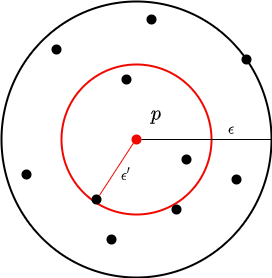

**Figure 3:** Visualizing core distance of point $p$

Figure 3 visualizes the core distance for a core point $p$ with $\varepsilon = 3$ and **MinPts = 4**. Since $p$’s neighborhood contains 4 neighbors within distance $\varepsilon'$, it is the core-distance for $p$, represented by the red line.

- **Reachability-distance**

For a data point $q \in D$ and a core point $p \in D$, the reachability distance between $p$ and $q$ is the distance between $p$ and $q$ such that $q$ is directly density-reachable from $p$ (Ankerst, 1999). Note that the reachability-distance cannot be less than the core-distance, because for a smaller distance the data point is not directly density-reachable from $p$.

Mathematically,
\[
\text{reachability-distance}_{\varepsilon,\text{MinPts}}(q, p) =
\begin{cases}
\text{undefined}, & \text{if } |N_{\varepsilon}(p)| < \text{MinPts} \\
\max\big(\text{core-distance}(p), \text{dist}(p, q)\big), & \text{otherwise}
\end{cases}
\]


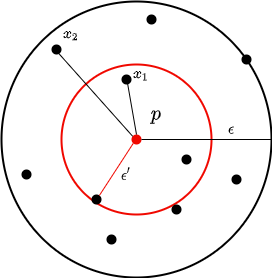

**Figure 4:** Visualizing reachability distance

Figure 4 visualizes the reachability distance for $x_1, x_2$ with respect to $p$. The reachability-distance is given as:

$$
\text{reachability-distance}_{\varepsilon,\text{MinPts}}(x_1, p)
= \max\big(\text{core-distance}(p), \text{dist}(p, x_1)\big)
= \text{core-distance}(p)
$$

$$
\text{reachability-distance}_{\varepsilon,\text{MinPts}}(x_2, p)
= \max\big(\text{core-distance}(p), \text{dist}(p, x_2)\big)
$$

Finally, we are ready to discuss the algorithm of OPTICS.
---

## Algorithm

We discuss the abstract algorithm and pseudo-code for OPTICS. This algorithm also requires finding neighbors. However, OPTICS uses the `find_neighbors` function instead of `range_query`. Unlike `range_query`, which finds the *directly density-reachable* points, `find_neighbors` retrieves all the *density-reachable* points from a core point.

The key point to remember is that OPTICS **orders the data points with respect to the reachability distance**. The order of computation is stored using a **priority queue (heap memory)** based on reachability distance. A priority queue is a data structure in which each element has an associated priority.

In short, OPTICS works as follows:

All data points are initially unprocessed with undefined reachability distance.

1. Select a random unprocessed data point, mark it as processed, and append it to the ordered list.
2. Calculate the core-distance. If the point is a core point, call the update function that:
3. Compute its neighbors w.r.t. $\varepsilon$ and **MinPts**.

4. Compute the reachability distance of those neighbors and update the priority of processing the neighbors.  
   **Note:** *Seed*, a priority queue, stores tuples  
   *(data point, reachability distance from nearest core point)*,  
   where smaller reachability distance gets higher priority.

Repeat steps 1–2 (except selection of data points) for the neighbors of each neighbor of the original core point until all are processed.

5. Go to step 1 until all data points are processed.  
6. Return the ordered list of locations according to reachability distance.

---

## Pseudo-code

Following is the pseudo-code for implementing the OPTICS algorithm.  
The `OPTICS` function returns the ordered list containing the density-based cluster order w.r.t. the reachability distance.

```text
OPTICS(DB, dist_func, eps, min_pts):

    for each point P in DB:
        P.reachability_dist = UNDEFINED   # Initializing reachability distance

    for each unprocessed point P in DB:
        Neighbors N = find_neighbors(DB, dist_func, P, eps)
            # Querying neighbours of the selected point

        mark P as processed
        output P to the ordered list
```text
if core_dist(P, eps, min_pts) != UNDEFINED:      # Checking if a data point is not an outlier
    Seeds = empty priority queue                # Initializing a priority queue

    update(N, P, Seeds, eps, min_pts, dist_func)  # Calling the update function

    for each next Q in Seeds:                   # Repeating the process for the neighbors
        Neighbors N' = find_neighbors(DB, dist_func, Q, eps)

        mark Q as processed
        output Q to the ordered list

        if core_dist(Q, eps, min_pts) != UNDEFINED:
            update(N', Q, Seeds, eps, min_pts, dist_func)

return ordered list



### Pseudo-code for **update*

The $update$ function calculates the reachability distance of neighbors from a given core point and assigns higher priority to smaller reachability distances. The reachability distance from the nearest core point is maintained. This ensures that the ordered output list contains data points belonging to the same cluster close to each other.
update(N, P, Seeds, eps, min_pts, dist_func):

    update(N, P, Seeds, eps, min_pts, dist_func):

    core_distance = core_dist(P, eps, min_pts)   # Calculating core distance for given point
    # Updating the Reachability
      # neighbour of P

      for Q in N:  # for each Q in neighbors N
               # distance for each
    
    if not Q.processed:
        new_reachability_dist = max(core_distance, dist_func(P, Q))
        
        # Checking if the neighbour point is in seeds
        if Q.reachability_dist is UNDEFINED:
            # Update step
            
            Q.reachability_dist = new_reachability_dist
            # Insertion to priority queue
            
            Seeds.insert(Q, new_reachability_dist)
        else:
            # Store shortest reachability distance
            if new_reachability_dist < Q.reachability_dist:
            
                Q.reachability_dist = new_reachability_dist
                
             # Moves smaller distance to higher priority
                Seeds.move_up(Q, new_reachability_dist)
The original paper generated cluster-ordering consisting of the ordering of points,
reachability-distance, and core-distance. However, the above pseudo-code
implementation uses only the ordering of points and reachability-distance,
which provides enough information for clustering.



## Runtime complexity

Since the `find_neighbors` function is similar to `range_query` used in DBSCAN,
and the function runs at least once for every point in the dataset, the runtime
complexity is from **O(n log n)** to **O(n²)** depending on use of spatial access
method and type of data.

In the original paper, the authors report OPTICS being **1.6 times slower**
than the DBSCAN algorithm.


## Reachability Plot for clustering

After ordering of clusters, one way to understand the structure of cluster-ordering
is using a graphical representation. The authors provide an interactive analysis
technique that uses the reachability plot for clustering the data points.

**Reachability plots** for a 2-dimensional dataset is a graph representing the
ordering of data points in the x-axis and respective reachability distance in the
y-axis.

**Note:** The reachability plot and its visualization are quite insensitive to the
parameters ε, MinPts (should be larger than "some" value found through hit and trial).


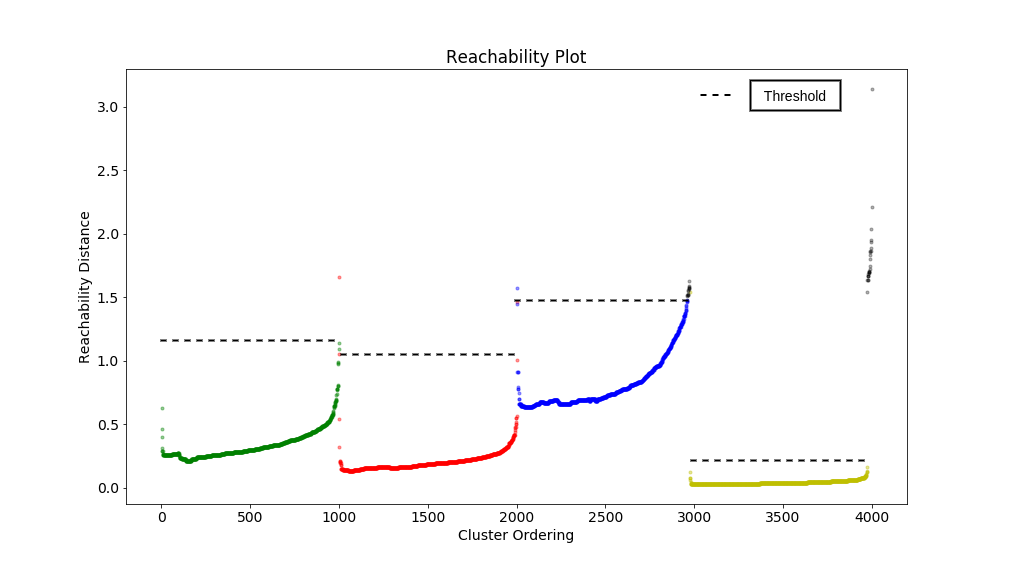

**Figure 6: Reachability plot for 2D dataset**

The figure above shows the reachability plot for the previously generated synthetic
dataset. As the data points in a cluster have similar reachability distance to its
nearest core point, the clusters appear as *valleys* (slight change in distance) in
the reachability plot. Deeper valleys (lower reachability distance) represent denser
clusters. The *peaks* in the reachability plots separate the clusters and represent
the distance required to travel between clusters or from cluster to noise to cluster.

As said before, OPTICS doesn't explicitly cluster the points; it only handles the
ordering of density-based ordering. The separation of clusters (assignment of colors
to a data point in figure 6) from reachability plot is done either by manually
selecting threshold (dotted line in figure 6) on the y-axis for a range of x-axis
values or by using an automatic algorithm that uses ξ parameter to compute steep
points and areas to detect start and end of valleys and cluster the data points
accordingly. Discussion of the **automatic technique** is beyond the scope of this
course, but if you are interested, do refer to section 4.3.1 of the paper linked in
the 1st subsection.

Let's plot the clusters obtained using density-based cluster-ordering and setting
threshold values.


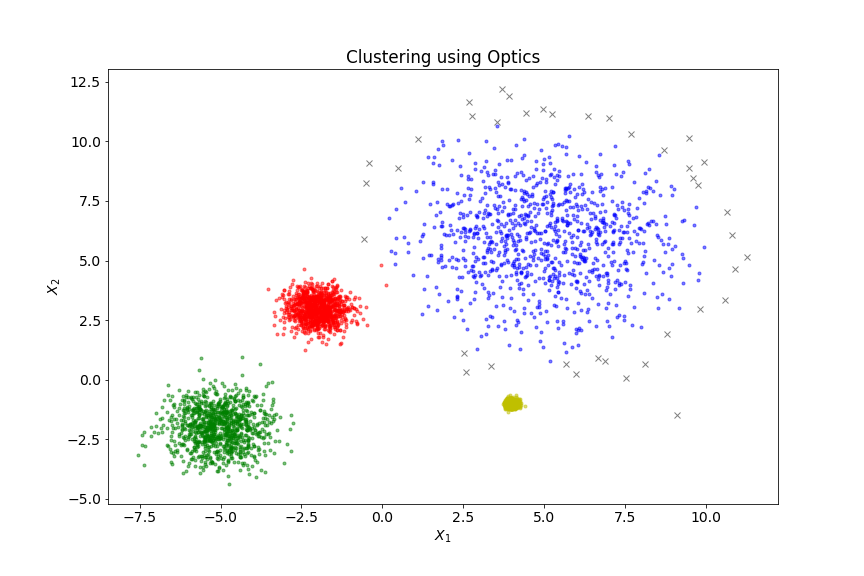

Figure 7: Clustering of synthetic dataset using OPTICS

Look how beautifully OPTICS algorithm clusters the varying density data in comparison to DBSCAN. Any points between the threshold region are labeled as noise. Comparing the cluster color with the reachability distance, the densest cluster represented by yellow color has the deepest valley, while the least dense cluster, represented by blue, has the shallowest valley. Though DBSCAN doesn't perform clustering using reachability plots, a conceptual comparison of the threshold for DBSCAN is presented in the figure below.



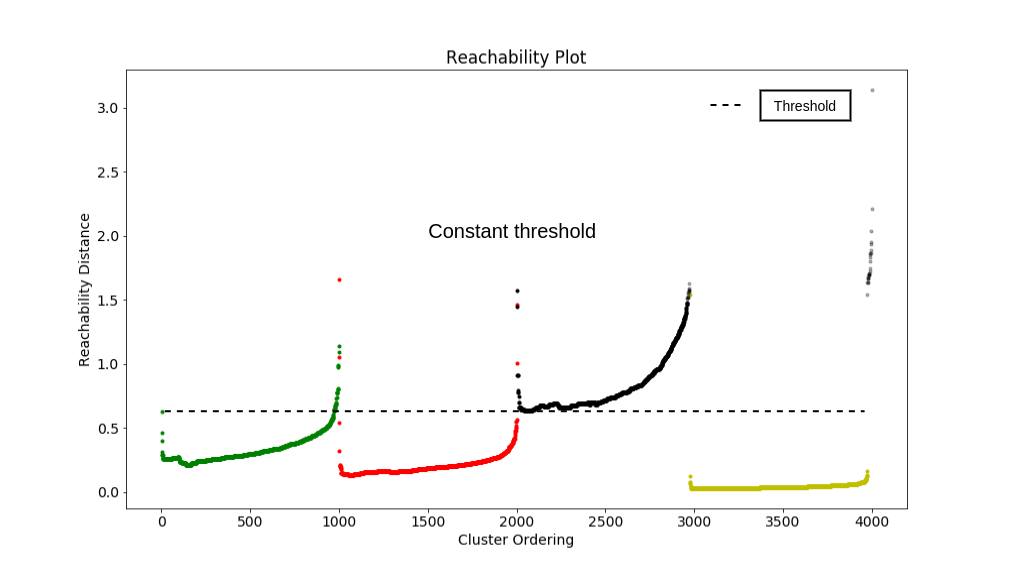

**Figure 8: Threshold for DBSCAN in reachability plot**

DBSCAN assumes constant density for all clusters, i.e., the threshold for separation
of clusters is constant. For example, if the threshold is set to 0.5, blue, red, and
yellow clusters are detected, but the previous blue cluster is labeled as noise.

This concludes the clustering of data points using the OPTICS algorithm. Finally,
let's move on to the discussion of the advantages and limitations of the OPTICS
algorithm.


## Pros / Cons

Similar to DBSCAN, OPTICS also has its pros and cons.

### Pros

1. Like DBSCAN, OPTICS doesn't require specification of the number of clusters and
   can detect outliers and cluster non-convex datasets.

2. Detects clusters of varying density.

3. More insensitive in terms of parameters ε and MinPts than DBSCAN, so it is known
   as a seemingly parameterless algorithm.

- ε influences the number/shape of clustering levels. A smaller value of ε results
  in the reachability distance of more data points being undefined. As a result, we
  might not see clusters with lower density. (Ankerst, 1999)

- MinPts only influences the smoothness of the reachability plot. Smaller values make
  the reachability plot more jagged, while larger values smoothen the plot.
  (Ankerst, 1999)


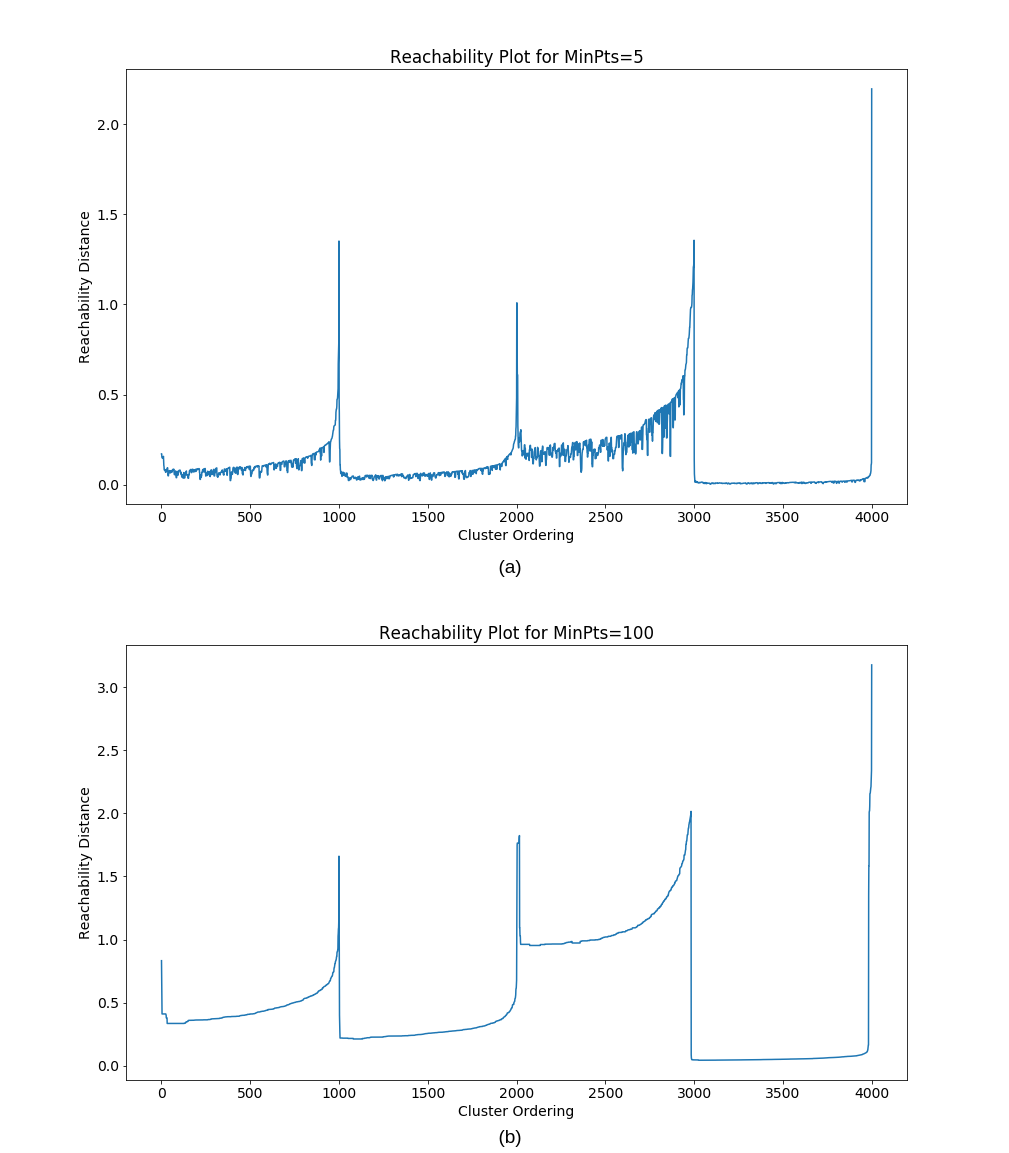

**Figure 9: Reachability plot for different value of MinPts**
(a) MinPts = 5 | (b) MinPts = 100

As you can see, the **MinPts** parameter only changes the smoothness of the
reachability plot. Lower value outputs a more jagged plot, but the valleys and
peaks of the reachability plot are preserved.

---

## Cons

1. Requires more memory than DBSCAN. It uses priority queues/min heaps to order
   the data points according to the reachability distance.

2. Slower than DBSCAN, approximately 1.6 times slower.

3. Unavailability of explicit cluster assignment, though some automatic
   assignment methods are present.

That's all for reading regarding OPTICS. In the next chapter, we are learning
the implementation of DBSCAN.

---

## Key-Takeaways

1. OPTICS is an extension of DBSCAN, which detects different density clusters
   using density-based cluster-ordering. However, OPTICS doesn't explicitly
   assign clusters to datapoints and is approximately 1.6 times slower than
   DBSCAN.

2. OPTICS consists of two additional terms known as **core-distance** and
   **reachability-distance** for gaining notion of density-based cluster-ordering:

   - **core-distance**: the smallest distance ε′ to classify a data point as a
     core point, given constant MinPts.

   - **reachability-distance**: for data points *p* and *q*, it is the distance
     between *p* and *q* such that *q* is directly density reachable from *p*.
     It must be equal to or greater than core-distance.

3. OPTICS orders the data points concerning the reachability distance from core
   points.

4. Explicit cluster assignment requires the help of a reachability plot where
   the x-axis represents ordering of data points and the y-axis represents
   reachability distance. The valleys represent clusters (deeper valley
   represents denser cluster) and peaks represent the separation of clusters.

5. Using a reachability plot, explicit cluster assignment is either done manually
   using the programmer's inspection or by using an automatic **ξ-method**.

6. Reachability plots are rather insensitive to input parameters ε and MinPts.
   So in OPTICS, the parameters must be selected above some value, obtained
   using hit and trial.

